In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import Optimization_function as opt
import copy

## Data Input and Parameters Setting

In [2]:
path = 'Data/backtest'
etf_price = pd.DataFrame(data = None)
col_name = []
for file in os.listdir(path):
    temp_df = pd.read_csv(path+'/'+file,index_col = 0)
    etf_price = etf_price.join(temp_df['Adj Close'], how = 'outer', rsuffix = '_'+file.replace('.csv',''))
    col_name.append(file.replace('.csv',''))
etf_price.columns = col_name

In [3]:
etf_price.head()

,DBC,GLD,SHY,SPIB,VB,VGLT,VO,VOO,VWO
Date,,,,,,,,,
2011-01-01,27.720127,129.869995,77.223198,24.846546,63.606075,45.028736,66.293297,97.050125,36.284428
2011-02-01,28.876345,137.660004,77.067108,24.854103,67.119446,45.659843,69.029724,100.414337,36.221985
2011-03-01,29.643923,139.860001,76.973221,24.754948,68.693520,45.608601,70.197540,99.969070,38.204388
2011-04-01,30.994463,152.369995,77.378723,25.200146,70.716682,46.604511,72.111229,103.365273,39.492184
2011-05-01,29.391300,149.639999,77.661613,25.463169,69.333832,48.164551,71.806122,102.156036,38.329273


In [22]:
etf_rtn = etf_price.pct_change()[1:]

In [60]:
window_length = 60 #Set 5 years as the window length to calculate parameters
t = 10 #Set risk tolerance parameter
eta = 0.95 #Set confidence level

## Optimization Implementation

In [83]:
monthly_return = pd.DataFrame(data = None, index = etf_rtn.index[window_length:], columns = ['mean_variance', 'robust'])
mv_weight = pd.DataFrame(data = None, index = etf_rtn.index[window_length:], columns = col_name)
robust_weight = pd.DataFrame(data = None, index = etf_rtn.index[window_length:], columns = col_name)
for i in range(len(etf_rtn) - window_length):
    sample_mean = etf_rtn.iloc[i:(i+window_length),:].mean().values
    sample_cov = etf_rtn.iloc[i:(i+window_length),:].cov().values
    sigma = np.diag(np.diag(sample_cov))/window_length
    
    w1 = opt.Markovitz_optimization(sample_mean, sample_cov, t)
    r1 = np.dot(w1.T, etf_rtn.iloc[(i+window_length),:].values)[0]
    
    w2 = opt.Robust_optimization(sample_mean, sample_cov, sigma, t, eta)
    r2 = np.dot(w2.T, etf_rtn.iloc[(i+window_length),:].values)[0]
    
    monthly_return.iloc[i, 0] = r1
    monthly_return.iloc[i, 1] = r2
    
    mv_weight.iloc[i, :] = w1.T
    robust_weight.iloc[i, :] = w2.T

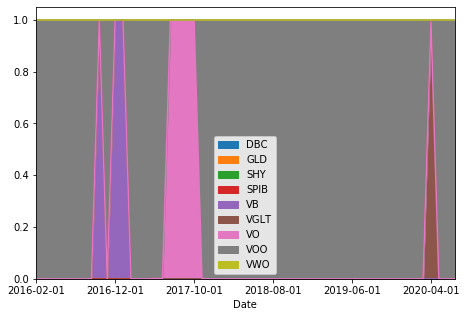

In [89]:
mv_weight.plot(figsize = (7.5,5), kind = 'area')

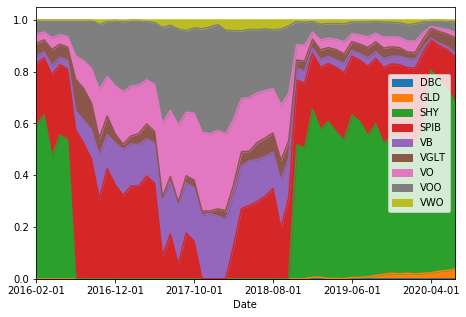

In [88]:
robust_weight.plot(figsize = (7.5,5), kind = 'area')

## Result Comparison

In [92]:
def portfolio_evaluation(portfolio_performance, risk_free_rate = 0.0):
    portfolio_evaluation = pd.DataFrame(data = None, index = portfolio_performance.columns)
    
    annual_rtn = pd.DataFrame(portfolio_performance.mean()*12)
    annual_rtn.columns = ['annualized return']
    annual_vol = pd.DataFrame(portfolio_performance.std()*np.sqrt(12))
    annual_vol.columns = ['annualized volatility']
    
    excess_rtn = portfolio_performance - risk_free_rate
    Sharpe_ratio = pd.DataFrame(excess_rtn.mean()*12/(excess_rtn.std()*np.sqrt(12)))
    Sharpe_ratio.columns = ['Sharpe ratio']
    
    cumulative_r = (portfolio_performance+1).cumprod()
    dd = 1-cumulative_r/cumulative_r.expanding(min_periods=1).max()
    MDD = pd.DataFrame(dd.max(axis = 0))
    MDD.columns = ['maximum drawdown']
    
    portfolio_evaluation = portfolio_evaluation.join(annual_rtn)
    portfolio_evaluation = portfolio_evaluation.join(annual_vol)
    portfolio_evaluation = portfolio_evaluation.join(Sharpe_ratio)
    portfolio_evaluation = portfolio_evaluation.join(MDD)
    
    return portfolio_evaluation

In [93]:
portfolio_evaluation(monthly_return.iloc[1:], risk_free_rate = 0.0)

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.111887,0.138293,0.809056,0.199094
robust,0.065556,0.053364,1.228458,0.065239


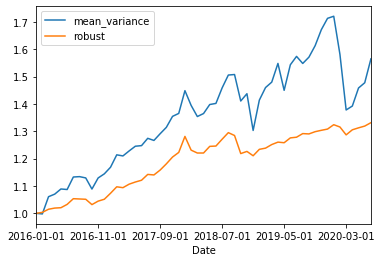

In [62]:
monthly_return_plt = copy.copy(monthly_return)
monthly_return_plt.loc[etf_price.index[window_length]] = 0.0